Working from https://www.nature.com/articles/ncomms3257#MOESM719 

## Strain's Role in the Timoshenko Model
The Timoshenko model is special because:

It connects differential strain to curvature: When two bonded layers experience different strains (one expands/contracts more than the other), the structure bends.
It accounts for both geometry and material properties: The model incorporates:

1. Thickness ratio (α = h₂/h₁)
2. Stiffness ratio (β = E₂/E₁)
3. The strain difference between layers (ε)


It provides a quantitative relationship: The equation relates curvature (κ) directly to strain (ε) and material properties:
κ = C · [6αβ(1+α)·ε] / [h₂ · (1 + 4αβ + 6α²β + 4α³β + α⁴β²)]

This is powerful because it lets you predict how much your structure will bend based on:

How much your material shrinks (strain)
The relative thickness of your layers
The relative stiffness of your layers



In [1]:
import pandas as pd
widths_df = pd.read_csv('/Users/yitongtseo/Documents/GitHub/cellulose_origami/timoshenko_modeling/layer_widths.tsv', sep='\t')


<Axes: xlabel='idx', ylabel='width'>

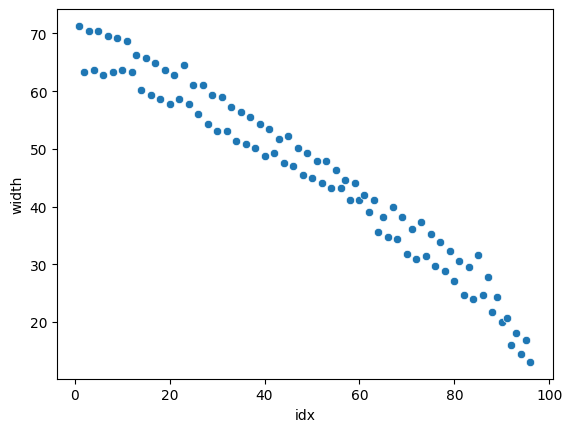

In [3]:
import seaborn as sns
sns.scatterplot(widths_df, x='idx', y='width')

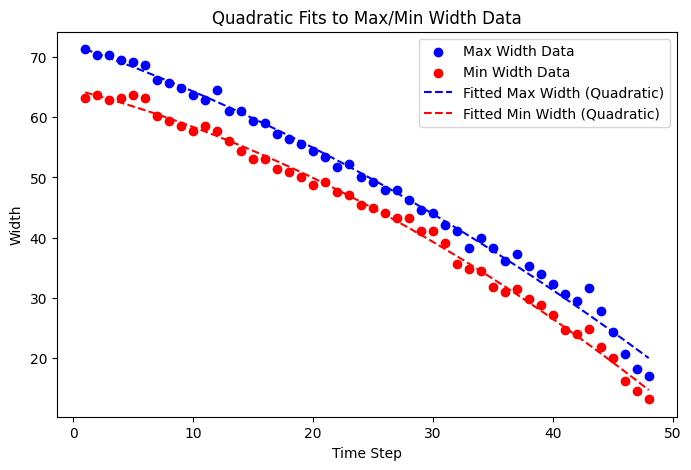

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load TSV file
df = pd.read_csv('/Users/yitongtseo/Documents/GitHub/cellulose_origami/timoshenko_modeling/layer_widths.tsv', sep='\t')

# Sort values by image_name and width, then separate max/min
sorted_df = df.sort_values(by=["image_name", "width"], ascending=[True, False])
df_max = sorted_df.groupby("image_name").first().reset_index()
df_min = sorted_df.groupby("image_name").last().reset_index()
# Extract numerical time steps from image_name
df_max["time"] = df_max["image_name"].str.extract(r'(\d+)$').astype(int)
df_min["time"] = df_min["image_name"].str.extract(r'(\d+)$').astype(int)

# Fit second-order polynomials
coeffs_max = np.polyfit(df_max["time"], df_max["width"], 2)
coeffs_min = np.polyfit(df_min["time"], df_min["width"], 2)

# Create polynomial functions
poly_max = np.poly1d(coeffs_max)
poly_min = np.poly1d(coeffs_min)

# Compute polynomial values and differences
time_steps = np.sort(df_max["time"].values)
fit_max = poly_max(time_steps)
fit_min = poly_min(time_steps)
difference = fit_max - fit_min

# Save results to DataFrame and CSV
results_df = pd.DataFrame({"time": time_steps, "difference": difference})
# results_df.to_csv("polynomial_difference.csv", index=False)

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(df_max["time"], df_max["width"], color="blue", label="Max Width Data")
plt.scatter(df_min["time"], df_min["width"], color="red", label="Min Width Data")
plt.plot(time_steps, fit_max, "--", color="blue", label="Fitted Max Width (Quadratic)")
plt.plot(time_steps, fit_min, "--", color="red", label="Fitted Min Width (Quadratic)")
plt.xlabel("Time Step")
plt.ylabel("Width")
plt.legend()
plt.title("Quadratic Fits to Max/Min Width Data")
plt.show()


In [9]:
results_df

,time,difference
0,1,7.180351
1,2,7.018103
2,3,6.861184
3,4,6.709594
4,5,6.563332
5,6,6.422399
6,7,6.286794
7,8,6.156519
8,9,6.031572
9,10,5.911953


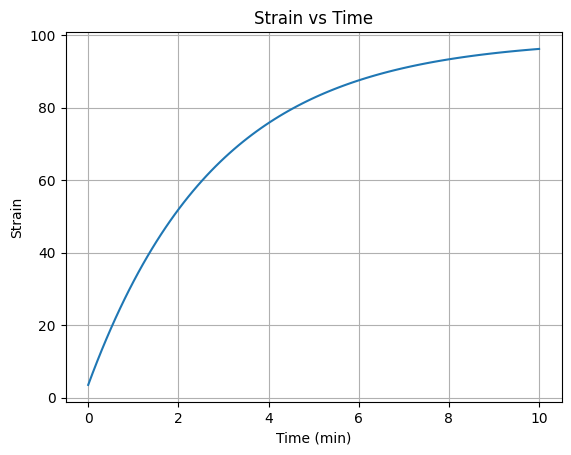

In [5]:
import numpy as np
# Strain parameters
A = 99
B = 95.5
tr = 2.83  # min

# Time points (in minutes)
t = np.linspace(0, 10, 100)  # Adjust range as needed

# Calculate strain using equation S4
def strain(t):
    return A - B * np.exp(-t/tr)

eps_values = strain(t)
import matplotlib.pyplot as plt
plt.plot(t, eps_values)
plt.xlabel('Time (min)')
plt.ylabel('Strain')
plt.title('Strain vs Time')
plt.grid()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define parameters
h_WT = 0.05  # mm, thickness of ionoprinted layer
h_BslA = 0.3   # mm (example value - you'll need to measure this for your system)
E_WT= 6.2 #MPa
E_BslA = 16.3 #MPa
C = 0.5     # Correction parameter

# Strain parameters
A = 99
B = 95.5
tr = 2.83  # min

# Time points (in minutes)
t = np.linspace(0, 10, 100)  # Adjust range as needed

# Calculate strain using equation S4
def strain(t):
    return A - B * np.exp(-t/tr)

# Calculate alpha and beta parameters
def alpha(h_WT):
    return h_WT/h_BslA

def beta(E_WT, E_BslA):
    return (E_WT/E_BslA)

# Calculate curvature using equation S2
def curvature(t, h_WT, E_WT):
    eps = strain(t)
    a = alpha(h_WT)
    b = beta(h_WT, E_WT)
    
    numerator = 6*a*b*(1+a)*eps
    denominator = h_WT * (1 + 4*a*b + 6*a**2*b + 4*a**3*b + a**4*b**2)
    
    return C * (numerator/denominator)

# Calculate radius of curvature
def radius(t, h_WT, E_WT):
    return 1/curvature(t, h_WT, E_WT)

# Plot results
eps_values = strain(t)
kappa_values = curvature(t, h_WT, E_WT)
R_values = radius(t, h_WT, E_WT)

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, eps_values)
plt.xlabel('Time (min)')
plt.ylabel('Strain ε')
plt.title('Strain vs Time')

plt.subplot(3, 1, 2)
plt.plot(t, kappa_values)
plt.xlabel('Time (min)')
plt.ylabel('Curvature κ (1/mm)')
plt.title('Curvature vs Time')

plt.subplot(3, 1, 3)
plt.plot(t, R_values)
plt.xlabel('Time (min)')
plt.ylabel('Radius R (mm)')
plt.title('Radius of Curvature vs Time')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Your measurements from the video
time_points = [...]  # Time points from your video
strain_values = [...]  # Strain calculated at each time point

# Define the strain model
def strain_model(t, A, B, tr):
    return A - B * np.exp(-t/tr)

# Fit the model to your data
params, covariance = curve_fit(strain_model, time_points, strain_values)
A_fitted, B_fitted, tr_fitted = params

# Plot results to verify the fit
t_fine = np.linspace(min(time_points), max(time_points), 100)
plt.figure(figsize=(10, 6))
plt.scatter(time_points, strain_values, label='Measured Strain')
plt.plot(t_fine, strain_model(t_fine, A_fitted, B_fitted, tr_fitted), 
         'r-', label=f'Fitted Model: A={A_fitted:.3f}, B={B_fitted:.3f}, tr={tr_fitted:.3f}')
plt.xlabel('Time (min)')
plt.ylabel('Strain')
plt.legend()
plt.title('Strain Evolution During Drying')
plt.grid(True)
plt.show()

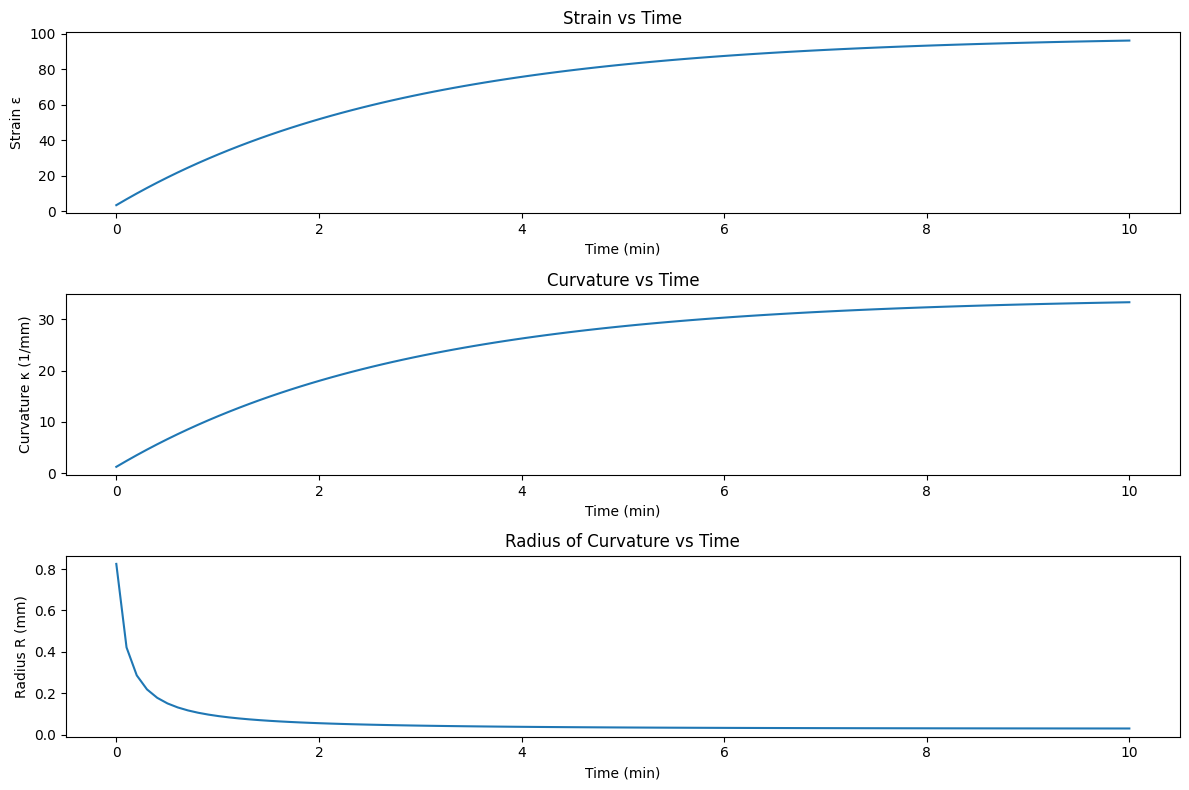

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define parameters
h_BslA = 0.05  # mm, thickness of ionoprinted layer
h_WT = 0.3   # mm (example value - you'll need to measure this for your system)
E_BslA = 300   # kPa
E_WT = 22    # kPa
E_WT_EtOH = 66  # kPa
C = 0.5     # Correction parameter

# Strain parameters
A = 99
B = 95.5
tr = 2.83  # min

# Time points (in minutes)
t = np.linspace(0, 10, 100)  # Adjust range as needed

# Calculate strain using equation S4
def strain(t):
    return A - B * np.exp(-t/tr)

# Calculate alpha and beta parameters
def alpha(h_WT):
    return h_WT/h_BslA

def beta(E_WT, E_BslA):
    return (E_WT/E_BslA)

# Calculate curvature using equation S2
def curvature(t, h_WT, E_WT):
    eps = strain(t)
    a = alpha(h_WT)
    b = beta(h_WT, E_WT)
    
    # Implement equation S2
    numerator = 6*a*b*(1+a)*eps
    denominator = h_WT * (1 + 4*a*b + 6*a**2*b + 4*a**3*b + a**4*b**2)
    
    return C * (numerator/denominator)

# Calculate radius of curvature
def radius(t, h_WT, E_WT):
    return 1/curvature(t, h_WT, E_WT)

# Plot results
eps_values = strain(t)
kappa_values = curvature(t, h_WT, E_WT)
R_values = radius(t, h_WT, E_WT)

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, eps_values)
plt.xlabel('Time (min)')
plt.ylabel('Strain ε')
plt.title('Strain vs Time')

plt.subplot(3, 1, 2)
plt.plot(t, kappa_values)
plt.xlabel('Time (min)')
plt.ylabel('Curvature κ (1/mm)')
plt.title('Curvature vs Time')

plt.subplot(3, 1, 3)
plt.plot(t, R_values)
plt.xlabel('Time (min)')
plt.ylabel('Radius R (mm)')
plt.title('Radius of Curvature vs Time')

plt.tight_layout()
plt.show()

In [ ]:
# Step 1: Fit strain parameters
# Measure how your material dimensions change during drying
time_points = [...]  # Your time measurements
strain_measurements = [...]  # How much your material has shrunk at each time

def strain_model(t, A, B, tr):
    return A - B * np.exp(-t/tr)

# Fit strain model to your measurements
strain_params, _ = curve_fit(strain_model, time_points, strain_measurements)
A_optimal, B_optimal, tr_optimal = strain_params

# Step 2: Fit the correction parameter C
def curvature_model(t, C):
    # Use your measured layer thicknesses
    h_1 = 0.05  # Your first layer thickness (mm)
    h_2 = 0.3   # Your second layer thickness (mm)
    
    # Use your measured Young's moduli
    E_1 = 300   # Young's modulus of first layer (kPa)
    E_2 = 22    # Young's modulus of second layer (kPa)
    
    # Use strain parameters from first fit
    A = A_optimal
    B = B_optimal
    tr = tr_optimal
    
    # Calculate strain at time t
    eps = strain_model(t, A, B, tr)
    
    # Thickness ratio
    a = h_2/h_1
    # Stiffness ratio
    b = E_2/E_1
    
    # Implement equation S2 from the paper
    numerator = 6*a*b*(1+a)*eps
    denominator = h_2 * (1 + 4*a*b + 6*a**2*b + 4*a**3*b + a**4*b**2)
    
    return C * (numerator/denominator)

# Fit C to your curvature measurements
curvature_params, _ = curve_fit(curvature_model, time_points, curvature_measurements)
C_optimal = curvature_params[0]